<a href="https://colab.research.google.com/github/syamkakarla98/Satellite_Imagery_Analysis/blob/main/Classification/Land_Cover_Classification_in_Satellite_Imagery_using_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font color='tomato'>Land Cover Classification in Satellite Imagery using Python</font>

In [1]:
!pip install earthpy gdal

     |████████████████████████████████| 752 kB 1.7 MB/s eta 0:00:01
    ERROR: Command errored out with exit status 1:
     command: /usr/bin/python3 -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-v5i9b70z/gdal/setup.py'"'"'; __file__='"'"'/tmp/pip-install-v5i9b70z/gdal/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' egg_info --egg-base /tmp/pip-pip-egg-info-xrjfjw6d
         cwd: /tmp/pip-install-v5i9b70z/gdal/
    Complete output (118 lines):
    running egg_info
    writing /tmp/pip-pip-egg-info-xrjfjw6d/GDAL.egg-info/PKG-INFO
    writing dependency_links to /tmp/pip-pip-egg-info-xrjfjw6d/GDAL.egg-info/dependency_links.txt
    writing requirements to /tmp/pip-pip-egg-info-xrjfjw6d/GDAL.egg-info/requires.txt
    writing top-level names to /tmp/pip-pip-egg-info-xrjfjw6d/GDAL.egg-info/top_level.txt
    Traceback (most recent call last

# Import Modules

In [32]:
!pip install thundersvm

     |████████████████████████████████| 507 kB 1.6 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [1]:
from glob import glob

import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep

import rasterio as rio
from rasterio.plot import plotting_extent
from rasterio.plot import show
from rasterio.plot import reshape_as_raster, reshape_as_image

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

from scipy.io import loadmat
from sklearn.metrics import classification_report, accuracy_score

import plotly.graph_objects as go

np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [2]:
%cd /tmp/shared


/tmp/shared


# Read Data

In [4]:
from glob import glob
S_sentinel_bands = glob("/tmp/shared/dataset22/*B?*.tiff")
S_sentinel_bands.sort()
S_sentinel_bands

['/tmp/shared/dataset22/2022-06-11-00_00_2022-06-11-23_59_Sentinel-2_L1C_B01_(Raw).tiff',
 '/tmp/shared/dataset22/2022-06-11-00_00_2022-06-11-23_59_Sentinel-2_L1C_B02_(Raw).tiff',
 '/tmp/shared/dataset22/2022-06-11-00_00_2022-06-11-23_59_Sentinel-2_L1C_B03_(Raw).tiff',
 '/tmp/shared/dataset22/2022-06-11-00_00_2022-06-11-23_59_Sentinel-2_L1C_B04_(Raw).tiff',
 '/tmp/shared/dataset22/2022-06-11-00_00_2022-06-11-23_59_Sentinel-2_L1C_B05_(Raw).tiff',
 '/tmp/shared/dataset22/2022-06-11-00_00_2022-06-11-23_59_Sentinel-2_L1C_B06_(Raw).tiff',
 '/tmp/shared/dataset22/2022-06-11-00_00_2022-06-11-23_59_Sentinel-2_L1C_B07_(Raw).tiff',
 '/tmp/shared/dataset22/2022-06-11-00_00_2022-06-11-23_59_Sentinel-2_L1C_B08_(Raw).tiff',
 '/tmp/shared/dataset22/2022-06-11-00_00_2022-06-11-23_59_Sentinel-2_L1C_B09_(Raw).tiff',
 '/tmp/shared/dataset22/2022-06-11-00_00_2022-06-11-23_59_Sentinel-2_L1C_B10_(Raw).tiff',
 '/tmp/shared/dataset22/2022-06-11-00_00_2022-06-11-23_59_Sentinel-2_L1C_B11_(Raw).tiff',
 '/tmp/sha

In [5]:
l = []
for i in S_sentinel_bands:
  with rio.open(i, 'r') as f:
    l.append(f.read(1))


In [6]:
arr_st = np.stack(l)

In [7]:
print(f'Height: {arr_st.shape[1]}\nWidth: {arr_st.shape[2]}\nBands: {arr_st.shape[0]}')

Height: 469
Width: 767
Bands: 13


# Visualize Data

## Bands

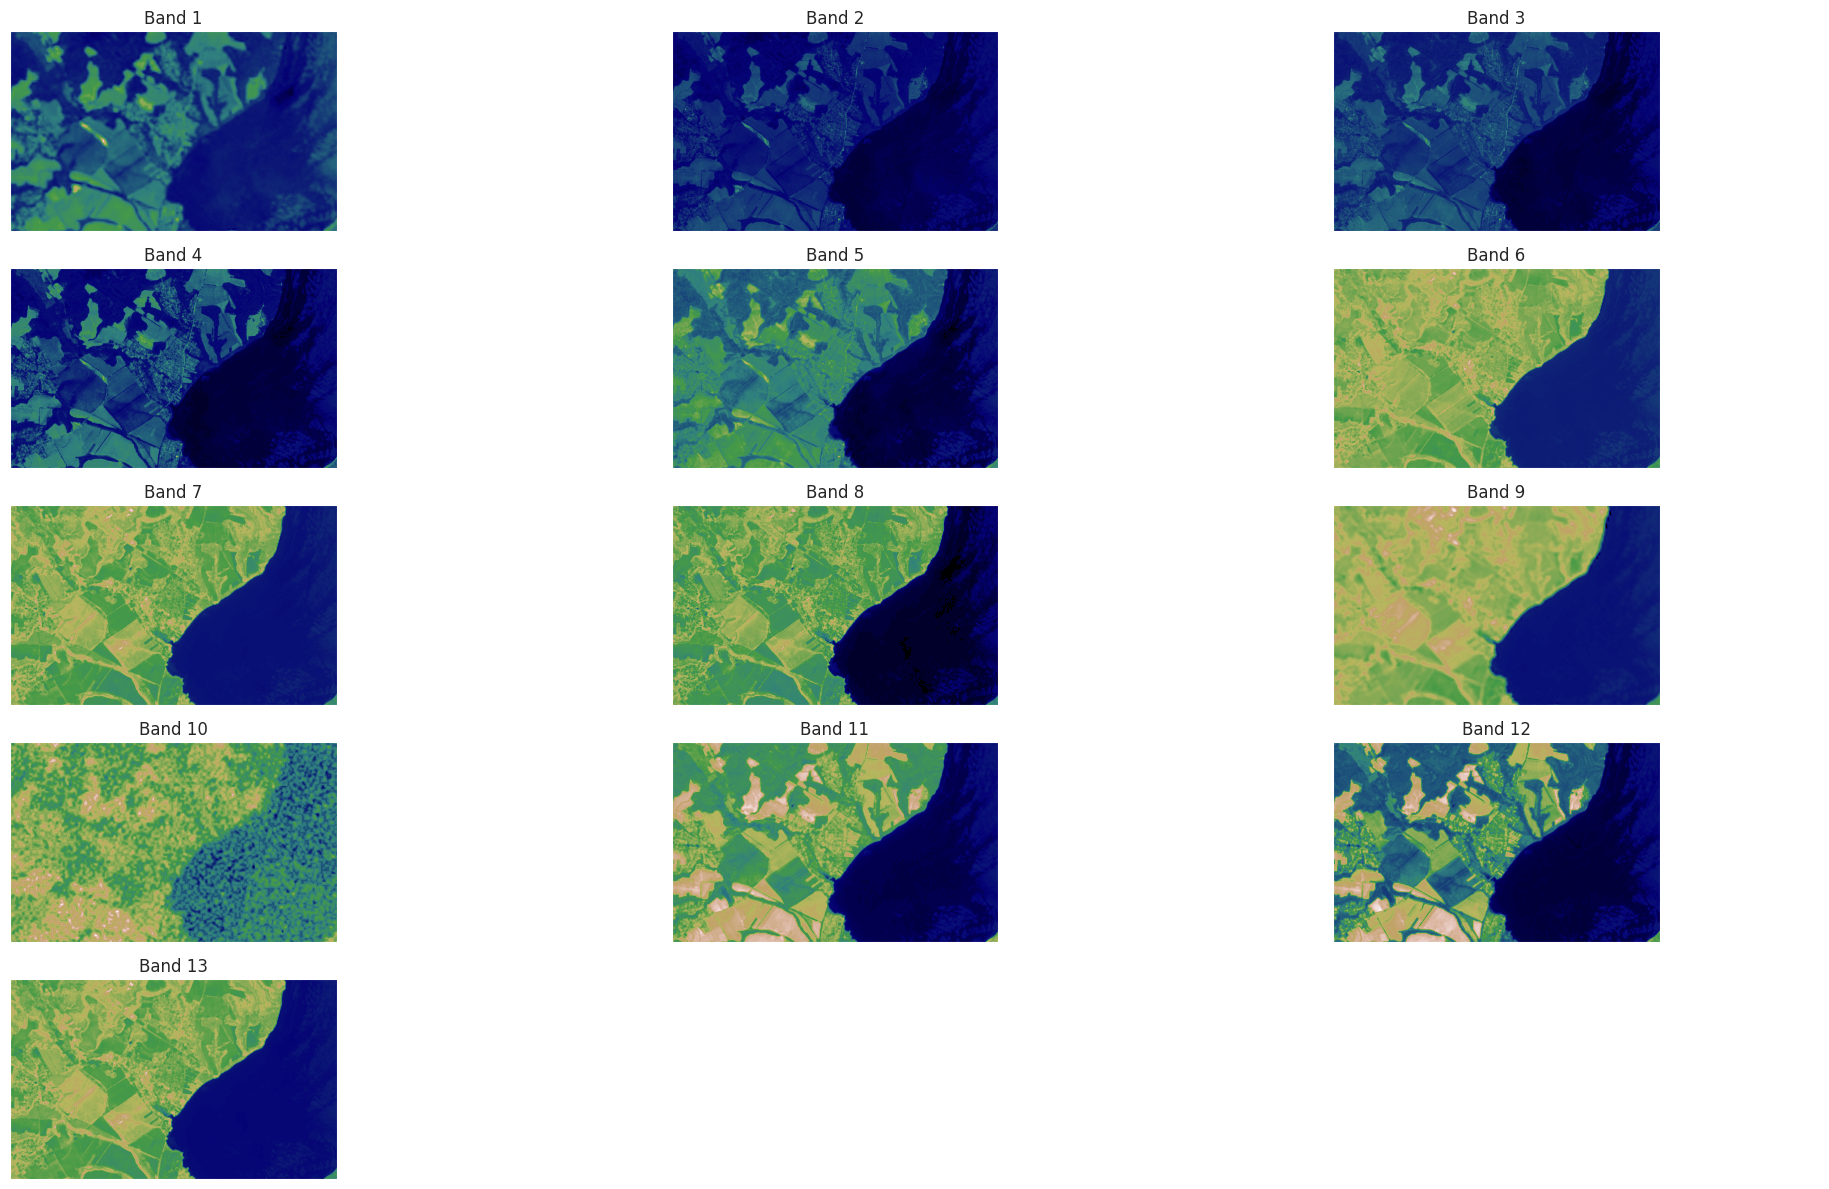

In [8]:
ep.plot_bands(arr_st, cmap = 'gist_earth', figsize = (20, 12), cols = 3, cbar = False)
plt.show()

## RGB Composite Image

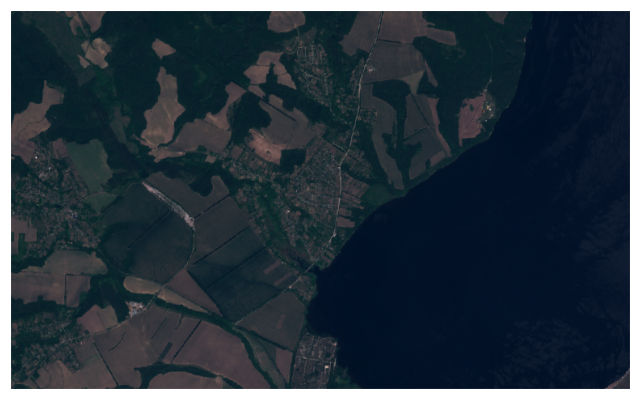

In [9]:
rgb = ep.plot_rgb(arr_st, 
                  rgb=(3,2,1), 
                  figsize=(8, 10), 
                  # title='RGB Composite Image'
                  )

plt.show()

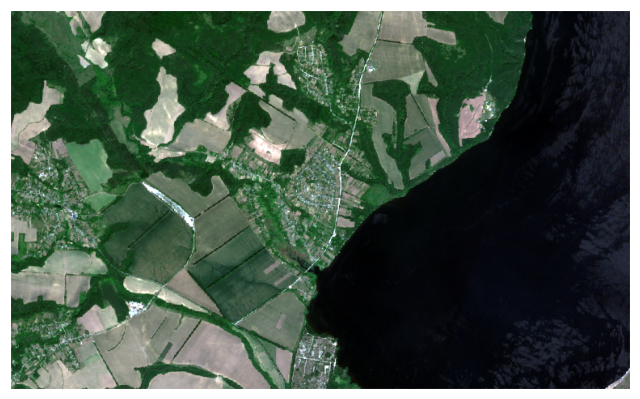

In [10]:
ep.plot_rgb(
    arr_st,
    rgb=(3, 2, 1),
    stretch=True,
    str_clip=0.2,
    figsize=(8, 10),
    # title="RGB Composite Image with Stretch Applied",
)

plt.show()

## Data Distribution of Bands

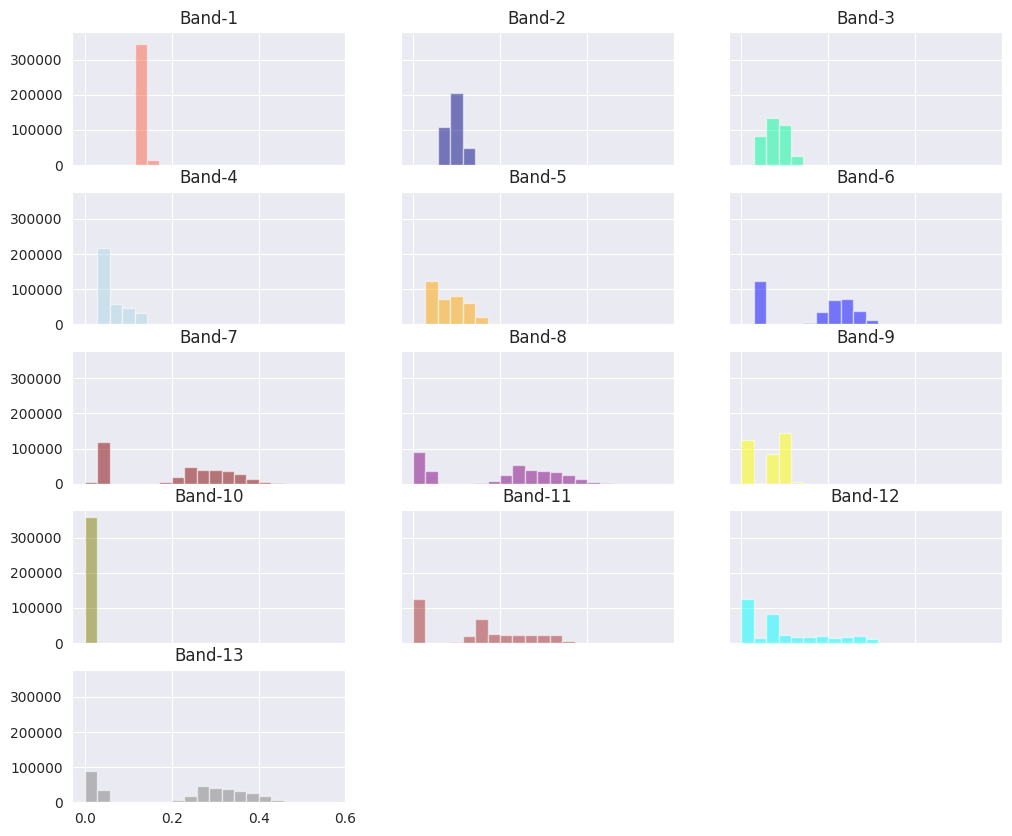

In [11]:
colors = ['tomato', 'navy', 'MediumSpringGreen', 'lightblue', 'orange', 'blue',
          'maroon', 'purple', 'yellow', 'olive', 'brown', 'cyan', 'gray']

ep.hist(arr_st,
        colors = colors,
        title=[f'Band-{i}' for i in range(1, 14)],
        cols=3, 
        alpha=0.5, 
        figsize = (12, 10)
        )

plt.show()

# Preprocessing 

In [12]:
x = np.moveaxis(arr_st, 0, -1)
x.shape

(469, 767, 13)

In [13]:
from sklearn.preprocessing import StandardScaler

X_data = x.reshape(-1, 13)

scaler = StandardScaler().fit(X_data)

X_scaled = scaler.transform(X_data)

X_scaled.shape

(359723, 13)

In [15]:
y_data = loadmat('/tmp/shared/dataset22/matlab.mat')['data']
y_data.shape

(469, 767)

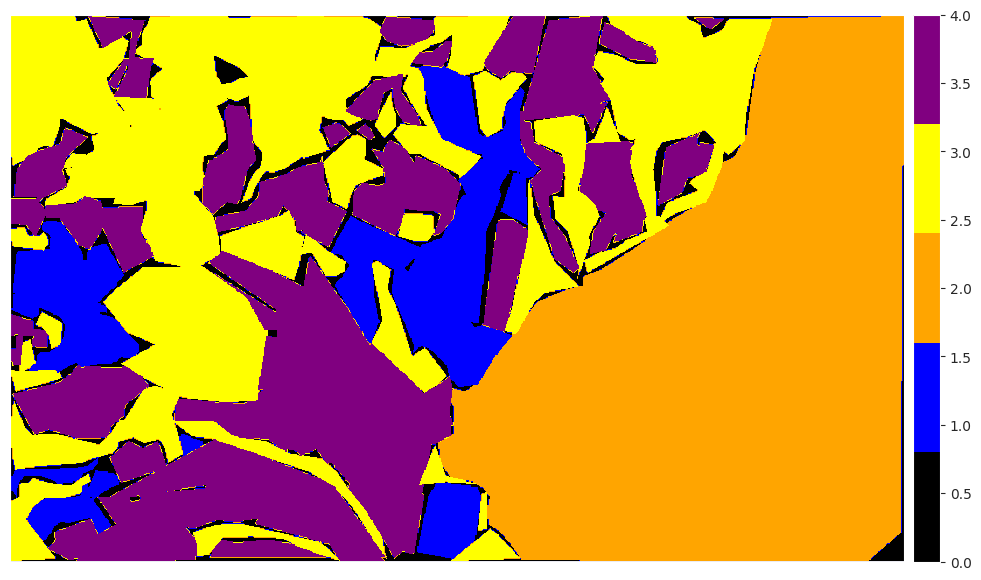

In [23]:
# Visualize Groundtruth

ep.plot_bands(y_data, cmap=ListedColormap(['black', 'blue', 'orange', 'yellow', 'purple']))
plt.show()

# Train Test Split

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_data.ravel(), test_size=0.30, stratify = y_data.ravel())

print(f'X_train Shape: {X_train.shape}\nX_test Shape: {X_test.shape}\ny_train Shape: {y_train.shape}\ny_test Shape:{y_test.shape}')

X_train Shape: (251806, 13)
X_test Shape: (107917, 13)
y_train Shape: (251806,)
y_test Shape:(107917,)


# K-Nearest Neighbor Classifier (K-NNC)



In [18]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=4)
knn.fit(X_train, y_train)

knn_pred = knn.predict(X_test)

In [19]:
print(f"Accuracy: {accuracy_score(y_test, knn_pred)*100}")

Accuracy: 86.33950165404895


In [20]:
print(classification_report(y_test, knn_pred))

              precision    recall  f1-score   support

           0       0.36      0.31      0.33      5955
           1       0.62      0.69      0.65      9703
           2       0.99      0.99      0.99     36449
           3       0.86      0.88      0.87     30077
           4       0.89      0.85      0.87     25733

    accuracy                           0.86    107917
   macro avg       0.74      0.74      0.74    107917
weighted avg       0.86      0.86      0.86    107917



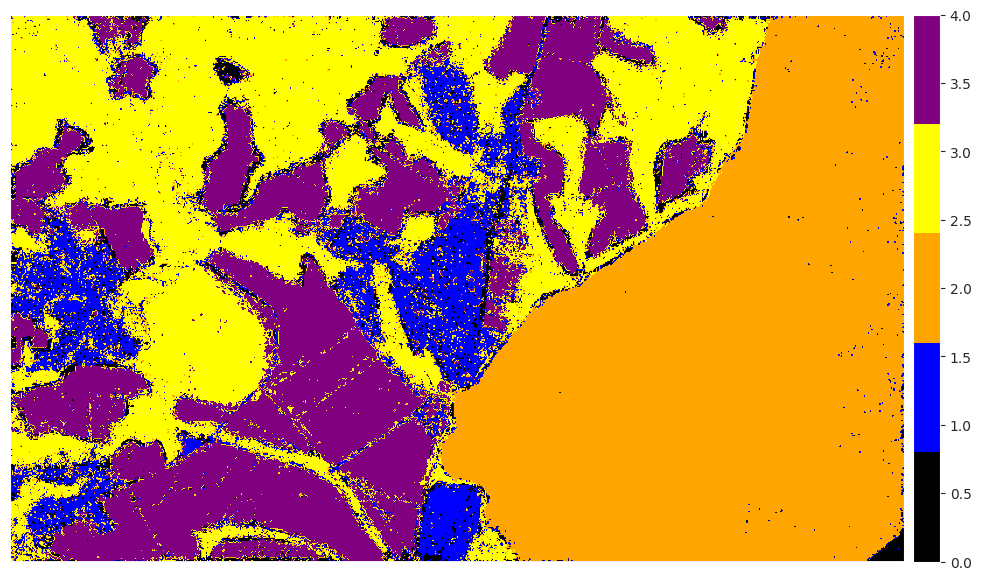

In [24]:
# Visualize Classification Map of K-NNC

ep.plot_bands(knn.predict(X_scaled).reshape((469, 767)),
              cmap=ListedColormap(['black', 'blue', 'orange', 'yellow', 'purple']))
plt.show()

# Support Vector Machine (SVM)

In [39]:
# #from sklearn.svm import SVC
# from thundersvm import SVC
# svm = SVC(C=1.0, kernel='poly', degree=3, cache_size=256)
# svm.fit(X_train, y_train)
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import RMSprop
from keras.regularizers import l2
import tensorflow.keras.backend as K
import numpy as np

In [85]:
#svm_pred = svm.predict(X_test)
#yy_train = tf.keras.utils.to_categorical(y_train, 4);
from keras.regularizers import l2
from keras.models import Sequential
from keras.layers import Dense,Activation

model = Sequential()
model.add(Dense(64, activation='relu'))
model.add(Dense(1,kernel_regularizer=l2(0.0001)))
model.add(Activation('linear'))
model.compile(loss='hinge',
              optimizer='adadelta',
              metrics=['accuracy'])

In [86]:
print(X_train[0])
xx_train = X_train.astype("float32") / 255;
model.fit(xx_train, y_train, epochs=10, batch_size=32)
#print(f"Accuracy: {accuracy_score(y_test, svm_pred)*100}")
accuracy = model.score(X_test, y_test)

print('Accuracy: {}'.format(accuracy))

[ 0.1868347   0.16014962  0.36031903  0.71520181  0.4286739   0.11318331
  0.03231824 -0.05883168  0.14827522 -0.04593687  1.22141485  1.51603983
  0.09802843]
Epoch 1/10
4096/8071 [==============>...............] - ETA: 4s - loss: 0.9383 - accuracy: 0.0791

KeyboardInterrupt: 

In [78]:
print(classification_report(y_test, svm_pred))

              precision    recall  f1-score   support

           0       0.54      0.16      0.24      8704
           1       0.90      0.96      0.93     13385
           2       0.72      0.50      0.59     31364
           3       0.62      0.90      0.73     32393
           4       0.82      0.82      0.82     24833

    accuracy                           0.72    110679
   macro avg       0.72      0.67      0.66    110679
weighted avg       0.72      0.72      0.70    110679



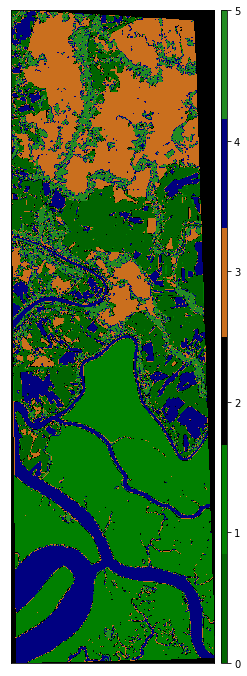

In [26]:
# Visualize Classification Map of SVM

ep.plot_bands(svm.predict(X_scaled).reshape((467, 790)),
              cmap=ListedColormap(['darkgreen', 'green', 'black', 
                                   '#CA6F1E', 'navy', 'forestgreen']))
plt.show()

# Light BGM

In [28]:
import lightgbm as lgb

d_train = lgb.Dataset(X_train, label=y_train)

params={}
params['learning_rate']=0.03
params['boosting_type']='gbdt' #GradientBoostingDecisionTree
params['objective']='multiclass' #Multi-class target feature
params['metric']='multi_logloss' #metric for multi-class
params['max_depth']=15
params['num_class']=6 #no.of unique values in the target class not inclusive of the end value

clf = lgb.train(params, d_train, 100)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007835 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 199004, number of used features: 12
[LightGBM] [Info] Start training from score -1.659694
[LightGBM] [Info] Start training from score -1.286046
[LightGBM] [Info] Start training from score -2.638465
[LightGBM] [Info] Start training from score -1.625235
[LightGBM] [Info] Start training from score -1.840073
[LightGBM] [Info] Start training from score -2.241496
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [29]:
lgb_predictions = clf.predict(X_test)

In [30]:
print(lgb_predictions[1], np.argmax(lgb_predictions[1]))

[1.87153833e-03 9.92787811e-01 7.34650792e-04 1.86637453e-03
 1.55373240e-03 1.18589340e-03] 1


In [31]:
# lbg_pred = [np.argmax(x) for x in lgb_predictions]
# np.array(lbg_pred).shape

lgb_pred = np.argmax(lgb_predictions, axis=1)
lgb_pred.shape

(85288,)

In [32]:
print(f"Accuracy: {accuracy_score(y_test, lgb_pred)*100}")

Accuracy: 98.93185442266204


In [33]:
print(classification_report(y_test, lgb_pred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98     16222
           1       1.00      0.99      1.00     23570
           2       1.00      1.00      1.00      6095
           3       0.99      0.99      0.99     16790
           4       0.99      0.99      0.99     13545
           5       0.96      0.97      0.97      9066

    accuracy                           0.99     85288
   macro avg       0.99      0.99      0.99     85288
weighted avg       0.99      0.99      0.99     85288



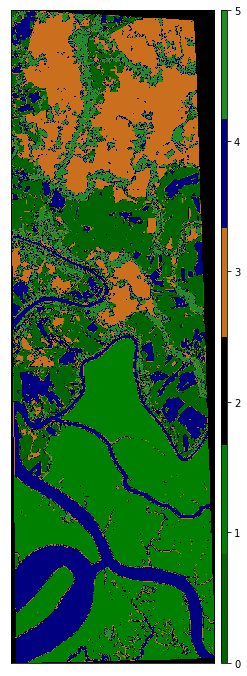

In [34]:
# Visualize Classification Map of LightGBM

ep.plot_bands(np.argmax(clf.predict(X_scaled), axis=1).reshape((954, 298)), 
              cmap=ListedColormap(['darkgreen', 'green', 'black', 
                                   '#CA6F1E', 'navy', 'forestgreen']))
plt.show()



---

